## Group No 43

## Group Member Names:
1. SHAILESH KUMAR SINGH 2023AC05475
2. JAWAHARLAL RAJAN S 2023AC05504
3. SUBHRANSU MISHRA 2023AC05489
4. LAKSHMISRINIVAS PERAKAM 2023AC05540

# 1. Import the required libraries

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import re
import string
import matplotlib.pyplot as plt
import pandas as pd
# Set device (TensorFlow automatically selects available GPU)
device = "GPU" if tf.config.list_physical_devices('GPU') else "CPU"

print(f"Using device: {device}")


Using device: GPU


# 2. Data Acquisition  -- Score: 0.5 Mark

For the problem identified by you, students have to find the data source themselves from any data source.

## 2.1 Code for converting the above downloaded data into a form suitable for DL



In [ ]:
# Load IMDB dataset from TensorFlow Datasets
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_data, test_data = dataset['train'], dataset['test']


## 2.1 Write your observations from the above.

1. Size of the dataset
2. What type of data attributes are there?
3. What are you classifying?
4. Plot the distribution of the categories of the target / label.



Size of Training Data: 25000
Size of Test Data: 25000

Data Attribute Types:
Review Text Type: <class 'str'>
Sentiment Label Type: <class 'numpy.int64'>

Negative Review Sample:
 This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
Label: Negative

Positive Review Sample:
 This is the kind of film for a snowy Sunday afternoon when the rest o

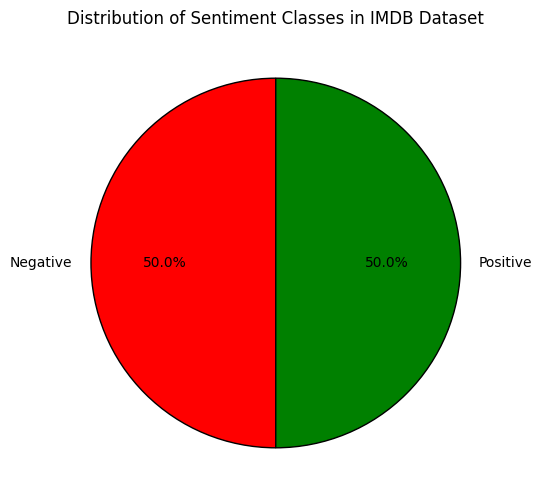

In [ ]:
# Print dataset size
print(f"Size of Training Data: {len(list(train_data))}")
print(f"Size of Test Data: {len(list(test_data))}")

# Extract data types of attributes
for text, label in train_data.take(1):
    print("\nData Attribute Types:")
    print(f"Review Text Type: {type(text.numpy().decode('utf-8'))}")  # Should be str
    print(f"Sentiment Label Type: {type(label.numpy())}")  # Should be int (0 or 1)

# Extract one positive and one negative sample
positive_sample = None
negative_sample = None

for text, label in train_data:
    if label.numpy() == 1 and positive_sample is None:
        positive_sample = (text.numpy().decode('utf-8'), "Positive")
    elif label.numpy() == 0 and negative_sample is None:
        negative_sample = (text.numpy().decode('utf-8'), "Negative")

    if positive_sample and negative_sample:
        break  # Stop once we have both samples

# Print the samples
print("\nNegative Review Sample:\n", negative_sample[0])
print("Label:", negative_sample[1])

print("\nPositive Review Sample:\n", positive_sample[0])
print("Label:", positive_sample[1])

# Classifying between positive (1) and negative (0) movie reviews
print("\nWe are classifying movie reviews into Positive (1) or Negative (0).")

# Count the number of positive and negative reviews
num_positive = sum(1 for _, label in train_data if label.numpy() == 1)
num_negative = sum(1 for _, label in train_data if label.numpy() == 0)

# Print the counts
print(f"Number of Positive Reviews: {num_positive}")
print(f"Number of Negative Reviews: {num_negative}")

# Plot a pie chart
plt.figure(figsize=(6, 6))
plt.pie([num_negative, num_positive], labels=['Negative', 'Positive'], autopct='%1.1f%%',
        colors=['red', 'green'], startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title("Distribution of Sentiment Classes in IMDB Dataset")
plt.show()


# 3. Data Preparation -- Score: 1 Mark

Perform the data prepracessing that is required for the data that you have downloaded.


This stage depends on the dataset that is used.

## 3.1 Apply pre-processing techiniques

* to remove duplicate data
* to impute or remove missing data
* to remove data inconsistencies
* Encode categorical data
* Normalize the data
* Feature Engineering
* Stop word removal, lemmatiation, stemming, vectorization


IF ANY

Let's do the following pre-processing steps.


In [ ]:
import pandas as pd

# Convert dataset to Pandas DataFrame for train and test
def dataset_to_dataframe(dataset):
    texts = [text.numpy().decode('utf-8') for text, label in dataset]
    labels = [label.numpy() for text, label in dataset]
    return pd.DataFrame({"review": texts, "label": labels})

# Convert train and test datasets
df_train = dataset_to_dataframe(train_data)
df_test = dataset_to_dataframe(test_data)

# Check and remove duplicates in both datasets
for name, df in [("Training", df_train), ("Test", df_test)]:
    num_duplicates = df.duplicated().sum()
    print(f"Number of Duplicate Entries in {name} Data: {num_duplicates}")

    if num_duplicates > 0:
      df.drop_duplicates(inplace=True)
      df.reset_index(drop=True, inplace=True)



Number of Duplicate Entries in Training Data: 96
Number of Duplicate Entries in Test Data: 199


In [ ]:
# Check for missing values in both datasets
for name, df in [("Training", df_train), ("Test", df_test)]:
    missing_values = df.isnull().sum()
    print(f"\nMissing Values in {name} Data:\n{missing_values}")

    # Drop missing values if any
    if missing_values.sum() > 0:
        df.dropna(inplace=True)



Missing Values in Training Data:
review    0
label     0
dtype: int64

Missing Values in Test Data:
review    0
label     0
dtype: int64


In [ ]:
# Checking for empty reviews in both datasets
for name, df in [("Training", df_train), ("Test", df_test)]:
    empty_reviews = (df['review'].str.strip() == "").sum()
    print(f"Number of Empty Reviews in {name} Data: {empty_reviews}")

    # Drop empty reviews if any
    if empty_reviews > 0:
        df = df[df['review'].str.strip() != ""].reset_index(drop=True)


Number of Empty Reviews in Training Data: 0
Number of Empty Reviews in Test Data: 0


In [ ]:
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # Remove punctuation
    text = re.sub("\\s+", " ", text).strip()  # Remove extra spaces
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Remove stopwords & lemmatize
    return " ".join(words)

# Apply preprocessing to both train and test datasets
for name, df in [("Training", df_train), ("Test", df_test)]:
    df["cleaned_review"] = df["review"].apply(preprocess_text)
    print(f"Preprocessing completed for {name} dataset.")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Preprocessing completed for Training dataset.
Preprocessing completed for Test dataset.


## 3.2 Identify the target variables.

* Separate the data front the target such that the dataset is in the form of (X,y) or (Features, Label)

* Discretize / Encode the target variable or perform one-hot encoding on the target or any other as and if required.





In [ ]:
##---------Type the code below this line------------------##

# Use TextVectorization with TF-IDF output for Dense layers
encoder = tf.keras.layers.TextVectorization(output_mode='tf-idf', max_tokens=10000)  # Limit vocabulary size

# Learn vocabulary and compute TF-IDF weights from training data
encoder.adapt(df_train["cleaned_review"].to_numpy())

# Print vocab size after adaptation
print(f"\nVocabulary Size After Adaptation: {len(encoder.get_vocabulary())}")

# Transform train and test sets into TF-IDF feature matrices
X_train = encoder(df_train["cleaned_review"]).numpy()
X_test = encoder(df_test["cleaned_review"]).numpy()

# Convert labels to numpy arrays
y_train = df_train["label"].to_numpy()
y_test = df_test["label"].to_numpy()





Vocabulary Size After Adaptation: 10000


## 3.3 Split the data into training set and testing set

In [ ]:
# The data is already split into training and test from the source
# Check the shape of the transformed data
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (24904, 10000), y_train shape: (24904,)
X_test shape: (24801, 10000), y_test shape: (24801,)


## 3.4 Preprocessing report

Mention the method adopted  and justify why the method was used
* to remove duplicate data, if present
* to impute or remove missing data, if present
* to remove data inconsistencies, if present
* to encode categorical data
* the normalization technique used

If the any of the above are not present, then also add in the report below.

Report the size of the training dataset and testing dataset


**The preprocessing methods are done above**
1. Removing Duplicates - Prevents overfitting by ensuring unique reviews.
2. Handling Missing Data - Avoids errors from empty reviews or labels.
3. Removing Data Inconsistencies - Cleans unnecessary symbols and formatting issues.
4. Encoding Categorical Data - Converts sentiment labels into numerical format.
5. Normalization - Maintains consistent review lengths for efficient processing.
6. Feature Engineering - Enhances sentiment detection by emphasizing important words.
7. Stop Word Removal - Reduces noise by eliminating non-informative words.
8. Lemmatization/Stemming - Standardizes word forms for better generalization.
9. Vectorization - Converts text into numerical representations for model training.

In [ ]:
##---------Type the answer below this line------------------##
print(f"Number of Training Samples: {len(df_train)}")
print(f"Number of Test Samples: {len(df_test)}")

Number of Training Samples: 24904
Number of Test Samples: 24801


# 4. Deep Neural Network Architecture - Score:  Marks


## 4.1 Design the architecture that you will be using

* Sequential Model Building with Activation for each layer.
* Add dense layers, specifying the number of units in each layer and the activation function used in the layer.
* Use Relu Activation function in each hidden layer
* Use Sigmoid / softmax Activation function in the output layer as required

DO NOT USE CNN OR RNN.

In [ ]:
def create_model():
  model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(X_train.shape[1],)),  # Input shape matches TF-IDF output
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  return model

model = create_model()


## 4.2 DNN Report

Report the following and provide justification for the same.



* Number of layers
* Number of units in each layer
* Total number of trainable parameters



In [ ]:
##---------Type the answer below this line------------------##
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │       1,280,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,289,217 (4.92 MB)

 Trainable params: 1,288,833 (4.92 MB)

 Non-trainable params: 384 (1.50 KB)

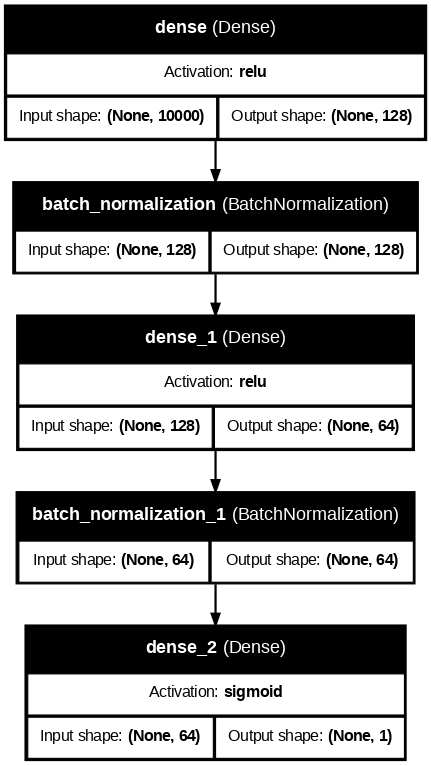

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, show_layer_activations=True, dpi=80)


# 5. Training the model - Score: 1 Mark


## 5.1 Configure the training

Configure  the model for training, by using appropriate optimizers and regularizations

Compile with categorical CE loss and metric accuracy.

In [ ]:
##---------Type the code below this line------------------##

# Function to compile & fit models
def compile_model(model, optimizer_type="SGD", learning_rate=0.01, momentum=0.9):
  print('Model compiling')

  if optimizer_type == "SGD":
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
    # Compile with SGD
  elif optimizer_type == "RMSProp":
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, rho=0.9)  # rho is decay factor
  elif optimizer_type == "Adam":
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
  else:
    raise ValueError("Unsupported optimizer type. Choose 'SGD', 'RMSProp', or 'Adam'.")

  model.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

  return model

def fit_model(model, X_train, y_train, X_test, y_test, verbose=0):
  print('Model training started')
  history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=64, verbose=verbose)
  return history


# Create and compile model
model = compile_model(model)

# Train initial model
history = fit_model(model, X_train, y_train, X_test, y_test, verbose=0)
histories_initial = {"Initial design (4.2)": history}



Model compiling
Model training started


## 5.2 Train the model

Train Model with cross validation, with total time taken shown for 20 epochs.

Use SGD.

In [ ]:
from sklearn.model_selection import KFold
import time
import itertools

# Define hyperparameter grid for SGD
LEARNING_RATES = [0.1, 0.005, 0.01]
MOMENTUMS = [0.8, 0.9, 0.95]

def train_model_cv(X_train, y_train, X_test, y_test, k=3):
    print('Cross-validation training started...')
    kf = KFold(n_splits=k, shuffle=True, random_state=42)  # 5-Fold Cross Validation

    best_hyperparams = None
    best_mean_accuracy = 0.0
    results = []

    start_time = time.time()  # Track total time

    # Iterate over all hyperparameter combinations
    for learning_rate, momentum in itertools.product(LEARNING_RATES, MOMENTUMS):
        print(f"\nEvaluating Hyperparameters: Learning Rate={learning_rate}, Momentum={momentum}")

        fold_accuracies = []
        fold_losses = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
            print(f"\nTraining Fold {fold+1}/{k}...")

            X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

            # Create and compile model
            model = create_model()
            model = compile_model(model, learning_rate=learning_rate, momentum=momentum)

            # Train on fold
            # enable verbose for just the first fold to reduce file size
            history = fit_model(model, X_train_fold, y_train_fold, X_val_fold, y_val_fold, verbose=1 if fold == 1 else 0)

            # Store accuracy & loss
            fold_accuracies.append(history.history['val_accuracy'][-1])
            fold_losses.append(history.history['val_loss'][-1])

            print(f"Fold {fold+1}: Accuracy={fold_accuracies[-1]:.4f}, Loss={fold_losses[-1]:.4f}")

        # Compute mean accuracy & loss for this hyperparameter set
        mean_accuracy = sum(fold_accuracies) / k
        mean_loss = sum(fold_losses) / k

        print(f"Mean Accuracy: {mean_accuracy:.4f}, Mean Loss: {mean_loss:.4f}")

        # Store results
        results.append((learning_rate, momentum, mean_accuracy, mean_loss))

        # Track the best hyperparameters
        if mean_accuracy > best_mean_accuracy:
            best_mean_accuracy = mean_accuracy
            best_hyperparams = (learning_rate, momentum)

    # Print total time taken
    total_time = time.time() - start_time
    print(f"\nTotal training time: {total_time:.2f} seconds")

    # Print best hyperparameters
    print(f"\nBest Hyperparameters: Learning Rate={best_hyperparams[0]}, Momentum={best_hyperparams[1]}")
    print(f"Best Mean Validation Accuracy: {best_mean_accuracy:.4f}")

    return results, best_hyperparams


In [ ]:
##---------Type the code below this line------------------##
# Train using cross validation for hyperparameter tuning
# uncomment to run cv again. It takes long time
_, best_hyperparams = train_model_cv(X_train, y_train, X_test, y_test)
(learning_rate, momentum) = best_hyperparams
print('Hyperparam learnt from cross validation',  learning_rate, momentum)

Cross-validation training started...

Evaluating Hyperparameters: Learning Rate=0.1, Momentum=0.8

Training Fold 1/3...
Model compiling
Model training started
Fold 1: Accuracy=0.8293, Loss=0.9176

Training Fold 2/3...
Model compiling
Model training started
Epoch 1/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6287 - loss: 0.6626 - val_accuracy: 0.5444 - val_loss: 1.6590
Epoch 2/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7850 - loss: 0.4804 - val_accuracy: 0.6132 - val_loss: 1.0028
Epoch 3/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8689 - loss: 0.3241 - val_accuracy: 0.6886 - val_loss: 0.6920
Epoch 4/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9039 - loss: 0.2439 - val_accuracy: 0.7024 - val_loss: 1.2912
Epoch 5/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9243 - loss: 0.2005 - val_accuracy: 0.8434 - val_loss: 0.3802
Epoch 6/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9400 - loss: 0.1648 - val_accuracy: 

Justify your choice of optimizers and regulizations used and the hyperparameters tuned


##---------Type the answers below this line------------------##

SGD updates parameters using mini-batches, making it efficient for large-scale training, less prone to overfitting, leading to better generalization on unseen data.

**What is the best learning_rate & momentum**?

The best learning rate and momentum is learnt from the above cross validation training.

**why binary_crossentropy?**

binary_crossentropy is used because this is a binary classification problem with a sigmoid activation function, ensuring proper probability-based loss computation.


In [ ]:
# final model based on cross validation
def train_model(model, verbose=0):
  model = compile_model(model, learning_rate=learning_rate, momentum=momentum)
  history = fit_model(model, X_train, y_train, X_test, y_test, verbose=1)
  return history

model = create_model()
history = train_model(model)

histories_5_2 = {"cross-validation (5.2)": history}


Model compiling
Model training started
Epoch 1/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7209 - loss: 0.5513 - val_accuracy: 0.5518 - val_loss: 1.2822
Epoch 2/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8568 - loss: 0.3374 - val_accuracy: 0.8442 - val_loss: 0.3620
Epoch 3/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8513 - loss: 0.3449 - val_accuracy: 0.8486 - val_loss: 0.3592
Epoch 4/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8950 - loss: 0.2577 - val_accuracy: 0.7001 - val_loss: 0.6687
Epoch 5/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9195 - loss: 0.2066 - val_accuracy: 0.6701 - val_loss: 0.9858
Epoch 6/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9349 - loss: 0.1759 - val_accuracy: 0.7597 - val_loss: 0.5976
Epoch 7/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9399 - loss: 0.1624 - val_accuracy: 0.6720 - val_loss: 1.0905
Epoch 8/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 

# 6. Test the model - 0.5 marks


In [ ]:
##---------Type the code below this line------------------##
model.evaluate(X_test, y_test)

776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8521 - loss: 0.3783


[0.37830257415771484, 0.8528285026550293]

# 7. Intermediate result  - Score: 1 mark

1. Plot the training and validation accuracy history.
2. Plot the training and validation loss history.
3. Report the testing accuracy and loss.
4. Show Confusion Matrix for testing dataset.
5. Report values for preformance study metrics like accuracy, precision, recall, F1 Score.


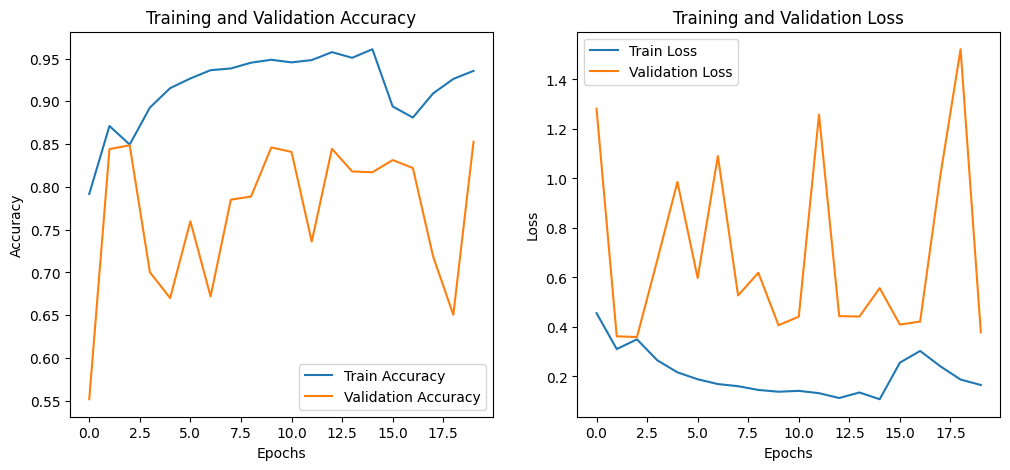

Test Accuracy: 0.8528
Test Loss: 0.3783
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


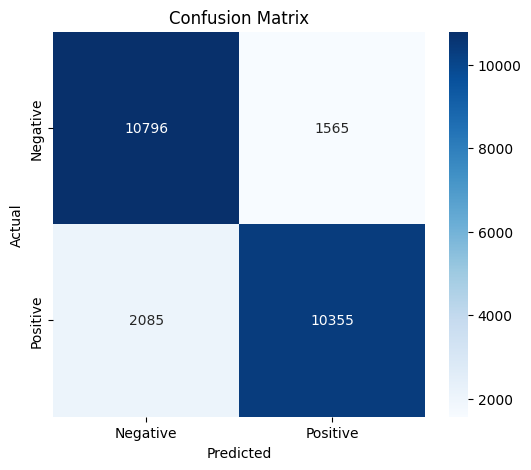

Accuracy: 0.8528
Precision: 0.8687
Recall: 0.8324
F1 Score: 0.8502


In [ ]:
##---------Type the code below this line------------------##

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

# Report Testing Accuracy and Loss
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Generate Predictions for Confusion Matrix
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary labels

# Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Report Performance Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 8. Model architecture - Score: 1 mark


Modify the architecture designed in section 4.1

1. by decreasing one layer
2. by increasing one layer

For example, if the architecture in 4.1 has 5 layers, then 8.1 should have 4 layers and 8.2 should have 6 layers.

Plot the comparison of the training and validation accuracy of the three architecures (4.1, 8.1 and 8.2)



In [ ]:
##---------Type the code below this line------------------##

histories_8 = {"original": history}

# Model with One Less Layer
model_less = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
# Model with One More Layer
model_more = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu'), # Added an extra layer
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

histories_8['model_less'] = train_model(model_less, verbose=0)
histories_8['model_more'] = train_model(model_more, verbose=0)

#

Model compiling
Model training started
Epoch 1/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.7288 - loss: 0.5735 - val_accuracy: 0.5531 - val_loss: 0.7623
Epoch 2/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8270 - loss: 0.4209 - val_accuracy: 0.7370 - val_loss: 0.5136
Epoch 3/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8495 - loss: 0.3740 - val_accuracy: 0.5217 - val_loss: 2.4582
Epoch 4/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8871 - loss: 0.2963 - val_accuracy: 0.6720 - val_loss: 0.7827
Epoch 5/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9099 - loss: 0.2424 - val_accuracy: 0.7788 - val_loss: 0.7302
Epoch 6/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9062 - loss: 0.2525 - val_accuracy: 0.5801 - val_loss: 1.3920
Epoch 7/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9103 - loss: 0.2517 - val_accuracy: 0.8514 - val_loss: 0.3661
Epoch 8/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy:

In [ ]:
import itertools
def comparision_plot(histories):
  plt.figure(figsize=(12, 6))
  colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])  # Cycle through colors

  for name, history in histories.items():
      color = next(colors)  # Get the next color from the cycle
      plt.plot(history.history['accuracy'], label=f"{name} Train", linestyle='-', color=color)
      plt.plot(history.history['val_accuracy'], label=f"{name} Validation", linestyle='--', color=color)

  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Training vs Validation Accuracy')
  plt.legend()
  plt.show()



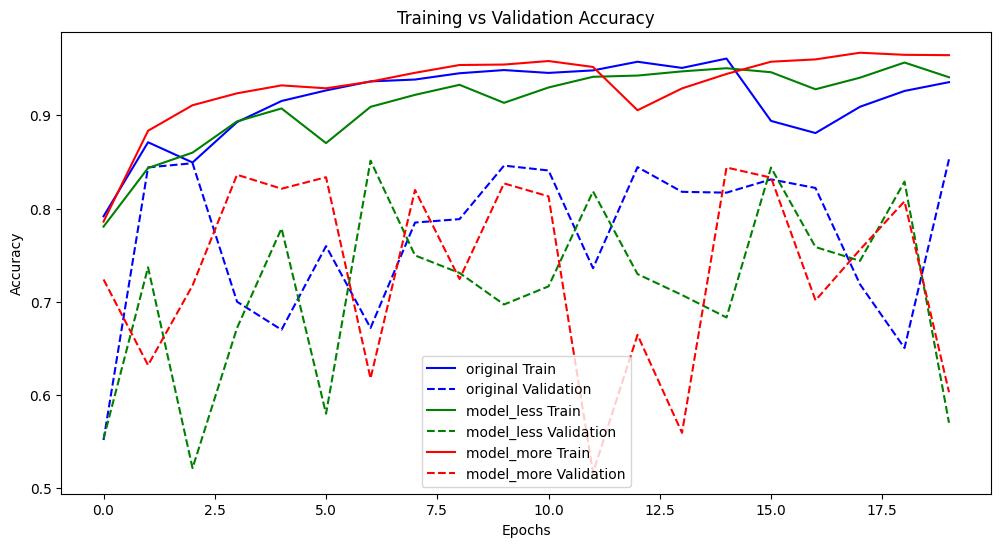

In [ ]:
comparision_plot(histories_8)

# 9. Regularisations - Score: 1 mark

Modify the architecture designed in section 4.1

1. Dropout of ratio 0.25
2. Dropout of ratio 0.25 with L2 regulariser with factor 1e−04.

Plot the comparison of the training and validation accuracy of the three (4.1, 9.1 and 9.2)



In [ ]:
##---------Type the code below this line------------------##

# 1. Dropout of ratio 0.25
model_dropout_25 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),  # Dropout layer with 25% dropout
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),  # Another dropout layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# 2. Dropout of ratio 0.25 with L2 regulariser with factor 1e−04.
from tensorflow.keras.regularizers import l2
model_dropout_l2_small = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),  # Dropout with 25%
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),  # Dropout with 25%
    tf.keras.layers.Dense(1, activation='sigmoid')
])
histories_9 = {"original": history}

print('Model with dropout 0.25')
histories_9['model_dropout_25'] = train_model(model_dropout_25)

print('Model with l2 regularisation, dropout 0.25')
histories_9['model_dropout_l2_small'] = train_model(model_dropout_l2_small)

Model with dropout 0.25
Model compiling
Model training started
Epoch 1/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6234 - loss: 0.6682 - val_accuracy: 0.7725 - val_loss: 0.5843
Epoch 2/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7566 - loss: 0.4993 - val_accuracy: 0.5161 - val_loss: 1.0595
Epoch 3/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7724 - loss: 0.4715 - val_accuracy: 0.6744 - val_loss: 0.5761
Epoch 4/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8310 - loss: 0.3771 - val_accuracy: 0.7247 - val_loss: 0.5229
Epoch 5/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8534 - loss: 0.3353 - val_accuracy: 0.8206 - val_loss: 0.4175
Epoch 6/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8570 - loss: 0.3187 - val_accuracy: 0.8736 - val_loss: 0.3152
Epoch 7/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8800 - loss: 0.2746 - val_accuracy: 0.7044 - val_loss: 0.7625
Epoch 8/20
390/390 ━━━━━━━━━━━━━━━━━━━━

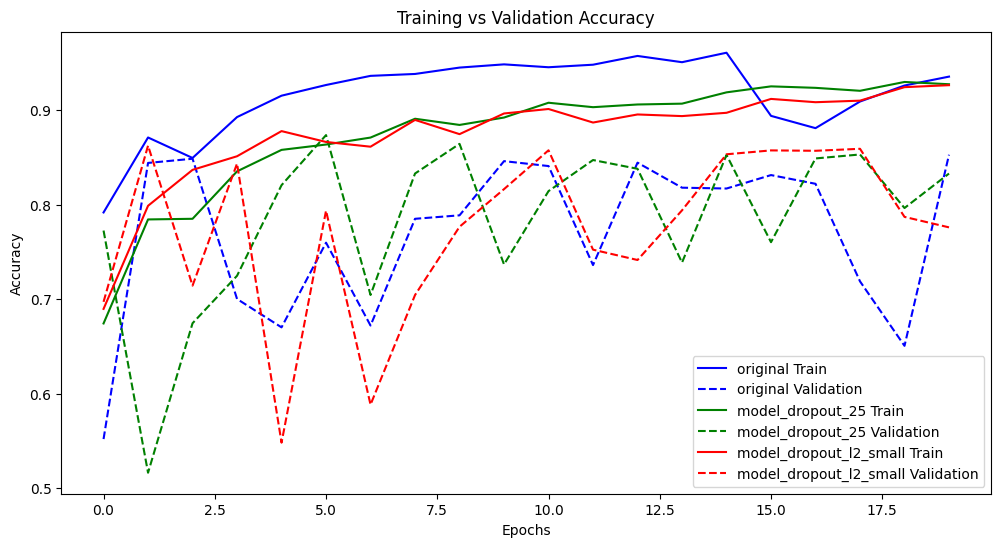

In [ ]:
comparision_plot(histories_9)

# 10. Optimisers -Score: 1 mark

Modify the code written in section 5.2

1. RMSProp with your choice of hyper parameters
2. Adam with your choice of hyper parameters

Plot the comparison of the training and validation accuracy of the three (5.2, 10.1 and 10.2)


RMSProp Settings:

learning_rate=0.001 (default: 0.001)
rho=0.9 (decay factor for moving average)
Good for training neural networks with unstable gradients.
Adam Settings:

learning_rate=0.001 (default)
beta_1=0.9 (momentum decay)
beta_2=0.999 (RMSProp-like adaptive learning rate)

In [ ]:
##---------Type the code below this line------------------##

histories_10 = {"original": history}

print('Model with optimizer RMSProp')

model = create_model()
model = compile_model(model, optimizer_type="RMSProp", learning_rate=0.001)
histories_10['RMSprop'] = fit_model(model, X_train, y_train, X_test, y_test, verbose=0)

print('Model with optimizer Adam')
model = create_model()
model = compile_model(model, optimizer_type="Adam", learning_rate=0.001)
histories_10['Adam'] = fit_model(model, X_train, y_train, X_test, y_test, verbose=0)

comparision_plot(histories_10)


Model with optimizer RMSProp
Model compiling
Model training started


# 11. Conclusion - Score: 1 mark

Comparing the sections 4.1, 5.2, 8, 9, and 10, present your observations on which model or architecture or regualiser or optimiser perfomed better.


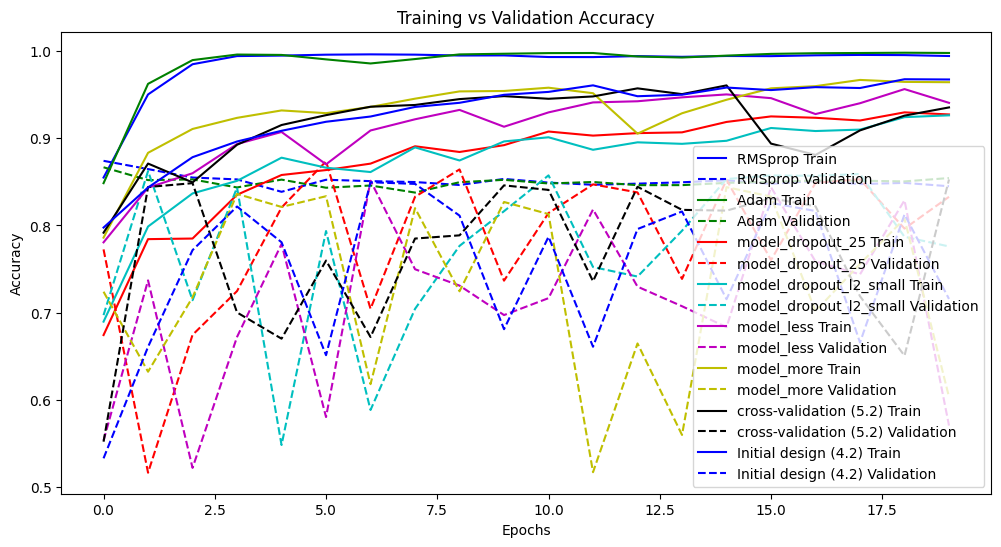

In [ ]:
##---------Type the code below this line------------------##

results = histories_10 | histories_9 | histories_8 | histories_5_2 | histories_initial
value = results.pop('original', None)  # remove duplicate keys

comparision_plot(results)

In [30]:
import pandas as pd

def comparison_table(histories, mode='last'):
    data = []

    for name, history in histories.items():
        epoch = len(history.history['accuracy'])
        if mode == 'last':
            acc = history.history['accuracy'][-1]
            val_acc = history.history['val_accuracy'][-1]
            mean_acc = sum(history.history['accuracy']) / epoch
            mean_val_acc = sum(history.history['val_accuracy']) / epoch
        elif mode == 'best_val':
            best_epoch = max(range(len(history.history['val_accuracy'])), key=lambda i: history.history['val_accuracy'][i]) + 1
            acc = history.history['accuracy'][best_epoch - 1]
            val_acc = history.history['val_accuracy'][best_epoch - 1]
            mean_acc = sum(history.history['accuracy'][:best_epoch]) / best_epoch
            mean_val_acc = sum(history.history['val_accuracy'][:best_epoch]) / best_epoch

        data.append([name, epoch, acc, val_acc, mean_acc, mean_val_acc])

    df = pd.DataFrame(data, columns=['Model', 'Epoch', 'Train Accuracy', 'Validation Accuracy', 'Mean Train Acc', 'Mean Val Acc'])
    print(df.to_string(index=False))

# Call with mode='best_val' to show the best epoch instead of last
print('Last Epoch Comparison')
comparison_table(results, mode='last')
print('-------- -------- -------- --------')
print('Best Epoch Comparison')
comparison_table(results, mode='best_val')


Last Epoch Comparison
                 Model  Epoch  Train Accuracy  Validation Accuracy  Mean Train Acc  Mean Val Acc
               RMSprop     20        0.994579             0.845047        0.985229      0.851242
                  Adam     20        0.998073             0.854482        0.986087      0.849762
      model_dropout_25     20        0.927482             0.832910        0.875436      0.785140
model_dropout_l2_small     20        0.926478             0.775936        0.874944      0.773969
            model_less     20        0.940813             0.570259        0.912779      0.713651
            model_more     20        0.964504             0.603081        0.932882      0.732678
cross-validation (5.2)     20        0.935553             0.852829        0.916194      0.769898
  Initial design (4.2)     20        0.967636             0.715657        0.928744      0.751000
-------- -------- -------- --------
Best Epoch Comparison
                 Model  Epoch  Train Accuracy  

* If we prioritize validation accuracy at the last epoch:
Adam has the highest Validation Accuracy (0.854482) at the last epoch.
RMSprop is slightly behind with 0.845047, but still strong.
* If we prioritize mean validation accuracy over all epochs:
RMSprop (0.851242) and Adam (0.849762) are very close.
Adam still has the edge in consistency over epochs.
* If you prioritize validation accuracy at the best epoch:
RMSprop (0.874239) has the best Validation Accuracy at its highest-performing epoch.
Adam (0.866820) is slightly behind.

**Conclusion:**

Best Model Overall is the model with optimizer RMSprop that has best validation accuracy at its peak: 0.8742.
Adam is the next choice (highest last-epoch validation accuracy: 0.8544).

### NOTE


All Late Submissions will incur a <b>penalty of -2 marks </b>. So submit your assignments on time.

Good Luck